# NCAR EdEc Bootcamp, Lesson 4

Supervised learning using decision trees

## Python Imports

In [4]:
import pandas as pd
import numpy as np

# Dataset
from palmerpenguins import load_penguins

# Plotting
import matplotlib.pyplot as plt

# Machine Learning
import sklearn
import xgboost as xgb
import catboost as cat

In [5]:
print('scikit-learn version:', sklearn.__version__)
print('XGBoost version:', xgb.__version__)
print('Catboost version:', cat.__version__)

scikit-learn version: 1.3.0
XGBoost version: 2.0.0
Catboost version: 1.2.1.1.16484


## Dataset Loading

We will be using this open source dataset to go through some ML workflow tasks:

https://essd.copernicus.org/articles/13/3013/2021/

In [6]:
df = pd.read_csv('http://hdl.handle.net/11304/89dd440e-4e10-496e-b476-1ccf0ebeb4f3')

In [7]:
df

,id,country,htap_region,climatic_zone,lon,lat,alt,relative_alt,type,type_of_area,...,o3_perc90,o3_perc98,o3_dma8eu,o3_avgdma8epax,o3_drmdmax1h,o3_w90,o3_aot40,o3_nvgt070,o3_nvgt100,dataset
0,3336,Germany,EUR,cool_moist,8.308210,54.924970,12.0,3,background,rural,...,46.4399,54.8468,53.5738,38.8078,50.7704,86.1266,10197.4742,2.0,0.0,test
1,3338,Germany,EUR,cool_moist,12.725280,54.436670,1.0,1,background,rural,...,44.0575,53.7778,51.3996,35.8313,48.3935,69.0987,7573.2222,1.0,0.0,train
2,3339,Germany,EUR,cool_moist,6.093923,50.754704,205.0,66,background,urban,...,41.1803,58.4009,54.9030,32.6169,49.8276,154.1263,8655.4730,5.4,1.0,train
3,3340,Germany,EUR,cool_moist,8.548389,52.023169,102.0,29,background,urban,...,38.1730,53.5109,50.1112,28.6179,46.2694,120.2575,6036.5851,2.6,0.0,test
4,3341,Germany,EUR,cool_moist,6.874554,51.862000,45.0,8,background,rural,...,40.6623,58.4082,53.9564,31.0051,50.6809,203.4584,9045.4745,6.8,1.2,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5572,17685,Germany,EUR,cool_moist,11.027920,49.322730,344.0,37,background,urban,...,42.4290,59.3735,56.0336,31.0232,51.5903,123.8122,10775.6201,3.5,0.0,train
5573,17718,Germany,EUR,cool_dry,11.850274,52.602056,35.0,5,background,urban,...,44.7611,58.4130,55.1136,34.8838,49.9512,146.6134,11145.3874,5.0,0.0,train
5574,17719,Germany,EUR,cool_dry,11.091078,51.456071,143.0,13,background,rural,...,43.4429,56.3841,54.4162,34.0865,49.3407,116.7581,9746.6681,2.5,0.0,val
5575,17720,Germany,EUR,cool_moist,13.420573,48.947611,858.0,76,background,rural,...,52.7680,63.9991,60.3341,41.3771,54.8419,108.2840,18120.8647,4.5,0.0,train


## Let's scale the dataset:

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [6]:
float_columns = df.select_dtypes(include=['float64', 'float32'])
float_column_names = float_columns.columns.tolist()
float_column_names

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

std_scaled = scaler.fit_transform(float_columns, y=None)
np.shape(std_scaled)

(333, 4)

Everything above this is the ~same as notebook 2

# Supervised ML

Supervised machine learning involves training algorithms on labeled datasets, where each data point is paired with its corresponding target outcome. The goal is to enable the algorithm to learn a mapping from inputs to outputs, allowing it to make accurate predictions on new, unseen data. The process includes two phases: a training phase where the model learns patterns from labeled examples, and an inference phase where it applies its learning to predict outcomes for new data. Common algorithms in supervised learning include decision trees, linear regression, and support vector machines.

#### 5 Supervised Algo's 

- Linear Regression: Predicts numerical values based on linear relationships between features and targets.

- Logistic Regression: Estimates the probability of class membership for binary classification tasks.

- Decision Trees: Versatile models for classification and regression, making decisions through sequential conditions.

- Random Forest: Ensemble of decision trees that provides robust predictions by combining multiple models.

- K-Nearest Neighbors (KNN): Makes predictions based on the majority class of the k-nearest data points in feature space.

We will cover two of these below, but scikit-learn can do all of these, with a nice overview [here](https://scikit-learn.org/stable/supervised_learning.html).

## Splitting Data

Note: For this exercise, we will just have a testing and a training dataset, not a validation dataset. For the final runthrough on day 2, we will have a validation dataset. All input features will be floats. 

In [8]:
from sklearn.model_selection import train_test_split

#### Regression split

Let's predict body mass from bill size and flipper size

In [9]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(std_scaled[:,0:3], std_scaled[:,3], test_size=0.33, random_state=42)

#### Classification split

We will predict specie from all measurements

In [10]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(std_scaled, df.species, test_size=0.33, random_state=42)

# Linear Models

## Linear Regression

By fitting a linear relationship between input features and target values, it enables you to make accurate predictions and understand the strength of correlations within your data, making it a fundamental tool in regression analysis.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_reg, y_train_reg)

LinearRegression()

In [13]:
# Make predictions on the test data
y_pred_reg = model.predict(X_test_reg)

# Calculate the Mean Squared Error (MSE) to evaluate the model's performance
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 0.21
R-squared: 0.76


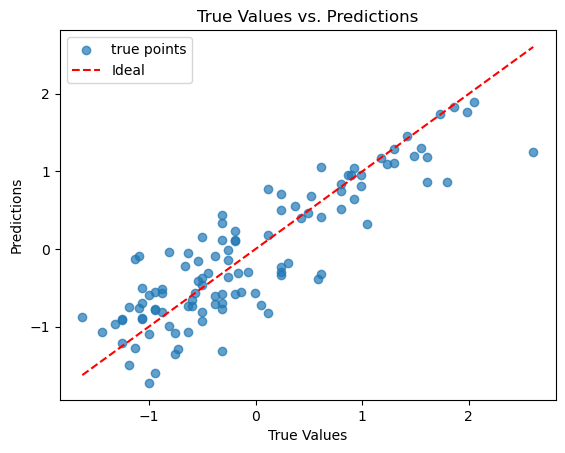

Learned Coefficients: [0.06765567 0.03770779 0.86091621]
Intercept: -0.012729203524484086


In [14]:
# Visualize the data and the regression line
plt.scatter(y_test_reg, y_pred_reg, alpha=0.70, label='true points')
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], linestyle='--', color='r', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions')
plt.legend()
plt.show()

# Print the learned coefficients
print("Learned Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

## Logistic Regression

Logistic regression is a statistical method used for binary classification, predicting the probability that an input belongs to one of two possible classes. It models the relationship between the input features and the binary outcome using the logistic function, which maps any input to a value between 0 and 1. This probability is then transformed into a predicted class label, making logistic regression a fundamental technique in machine learning and statistics.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# note, we will go over metrics tomorrow! For now, just pretend it's magic

The next code cell will error out without some additional lines of code

In [ ]:
# Create a Logistic Regression model
model_clf = LogisticRegression()

## Rest of the your code here!



## Some code that might help
# Calculate the accuracy and confusion matrix to evaluate the model's performance
accuracy = accuracy_score(y_test_clf, y_pred_clf)
conf_matrix = confusion_matrix(y_test_clf, y_pred_clf)
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

# Print the learned coefficients
print("Learned Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

## SGD

Stochastic Gradient Descent (SGD) is a widely used machine learning technique for regression tasks. It involves iteratively adjusting model parameters to minimize the difference between predicted and actual target values. Unlike traditional gradient descent, SGD updates the parameters using small random subsets (batches) of the training data, making it computationally efficient for large datasets. In each iteration, it computes the gradient of the loss with respect to the parameters using the current batch, and then adjusts the parameters in the opposite direction of the gradient's steepest descent. This process is repeated for multiple epochs until convergence, resulting in a regression model that can effectively capture patterns and relationships in the data.

In [16]:
from sklearn.linear_model import SGDRegressor

In [17]:
# Create an SGD Regressor model
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)

In [18]:
# Create a Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model_sgd.fit(X_train_reg, y_train_reg)

SGDRegressor(random_state=42)

In [19]:
# Make predictions on the test data
y_pred_sgd = model_sgd.predict(X_test_reg)

# Calculate the Mean Squared Error (MSE) to evaluate the model's performance
mse = mean_squared_error(y_test_reg, y_pred_sgd)
r2 = r2_score(y_test_reg, y_pred_sgd)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 0.22
R-squared: 0.74


Is there a difference in metrics compared to the earlier linear model?

Stochastic Gradient Descent (SGD) is a fundamental building block for training neural networks. Neural networks, especially deep neural networks, are trained using optimization algorithms, and SGD is one of the most commonly used optimization techniques in this context.

Neural networks consist of layers of interconnected nodes (neurons) that process and transform data. During the training process, the network learns to adjust its weights and biases to minimize the difference between predicted and actual outputs. This optimization process involves finding the optimal values for these weights and biases to make the network's predictions as accurate as possible.

SGD comes into play during this optimization process. The goal is to find the values of the weights and biases that minimize a predefined loss function, which quantifies the discrepancy between predictions and actual targets. SGD helps in this process by iteratively updating the model's parameters in the direction that reduces the loss.

Here's how SGD works in training neural networks:

- Mini-Batch Processing: Instead of processing the entire training dataset in one go (which could be computationally expensive), SGD processes small subsets of the data, known as mini-batches, in each iteration.

- Gradient Calculation: For each mini-batch, the gradient of the loss function with respect to the model's parameters (weights and biases) is computed. This gradient indicates the direction of steepest increase in the loss.

- Parameter Update: The parameters are updated by subtracting a fraction of the gradient (scaled by a learning rate) from their current values. This update step is performed for each mini-batch.

- Iteration and Convergence: The process of calculating gradients and updating parameters is repeated for multiple iterations (epochs) until the loss converges to a minimum or stabilizes.

- Noise and Exploration: The stochastic nature of SGD—due to the random selection of mini-batches—introduces noise into the optimization process. This noise can help the optimization algorithm escape local minima and explore the parameter space more effectively.

Neural networks often use variants of SGD to improve convergence speed and stability. For instance, "Adam" and "RMSProp" are popular optimization algorithms that adaptively adjust the learning rate for each parameter based on their historical gradients. These algorithms combine the benefits of SGD with more sophisticated mechanisms for adjusting the learning rate, leading to faster and more stable training.

In essence, SGD forms the basis for training neural networks, enabling them to learn complex patterns and relationships in data by iteratively adjusting their parameters to minimize the prediction error.

**Neural Networks will be covered in the next course**

# Non-Linear Models

## K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) is advantageous in supervised machine learning due to its simplicity and versatility. KNN's ability to adapt to different data distributions and handle multi-class problems makes it suitable for various scenarios. Its non-parametric nature eliminates the need for assumptions about data distribution, allowing it to capture complex decision boundaries. KNN's effectiveness, especially when combined with appropriate distance metrics and optimization techniques, makes it a valuable tool for supervised ML tasks.

## Classification

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# Create a KNeighborsClassifier model
model = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
model.fit(X_train_clf, y_train_clf)

# Make predictions on the test data
y_pred_knn_clf = model.predict(X_test_clf)

# Calculate the accuracy and confusion matrix to evaluate the model's performance
accuracy = accuracy_score(y_test_clf, y_pred_knn_clf)
conf_matrix = confusion_matrix(y_test_clf, y_pred_knn_clf)
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

# Print the learned classes for each label
print("Learned Classes:", model.classes_)

Accuracy: 0.98
Confusion Matrix:
[[52  0  0]
 [ 2 23  0]
 [ 0  0 33]]
Learned Classes: ['Adelie' 'Chinstrap' 'Gentoo']


## Regression

In [ ]:
# write your KNN regression code here!

# Next steps

Tomorrow we will get to tree based methods!

the end